# Бредис Георгий ДЗ-4

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import f

# Пункт 1

In [2]:
data = pd.read_stata('unemp_dz4.dta')

In [3]:
data['quarter'] = np.arange(len(data))

In [4]:
lin = np.polyfit(x=data['quarter'], y=data['unemp'], deg=9)
p = np.poly1d(lin)

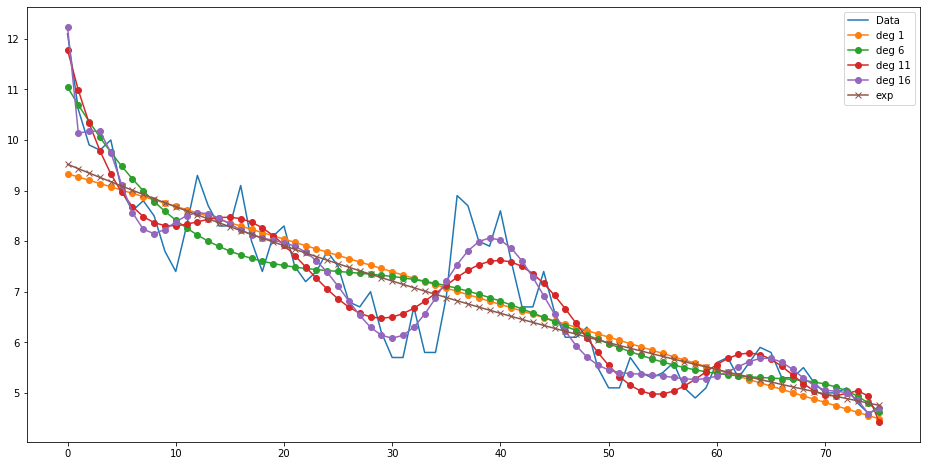

In [5]:
diffs = pd.DataFrame()
plt.figure(figsize=[16, 8])
plt.plot(data['quarter'], data['unemp'], label='Data')
for i in range(1, 20, 5):
    coef = np.polyfit(x=data['quarter'], y=data['unemp'], deg=i)
    p = np.poly1d(coef)
    plt.plot(data['quarter'], p(data['quarter']), label='deg {}'.format(i), marker='o')
    diffs[str(i)] = (p(data['quarter'])-data['unemp'])**2
    
coef = np.polyfit(x=data['quarter'], y=np.log(data['unemp']), deg=1)
p = np.poly1d(coef)
plt.plot(data['quarter'], np.exp(p(data['quarter'])), label='exp', marker='x')
diffs['exp'] = (np.exp(p(data['quarter']))-data['unemp'])**2
plt.legend()
plt.show()

In [6]:
diffs.mean(axis=0)

1      0.665563
6      0.494650
11     0.254429
16     0.180743
exp    0.619830
dtype: float64

Построив несколько кривых роста, мы выяснили что на обучающей выборке лучшей объясняющей способностью обладает полиномы высоких степеней. Но их генерализующую способность мы не можем оценить за неимением валидационной выборке (без деления исходных данных)..

# Пункт 2

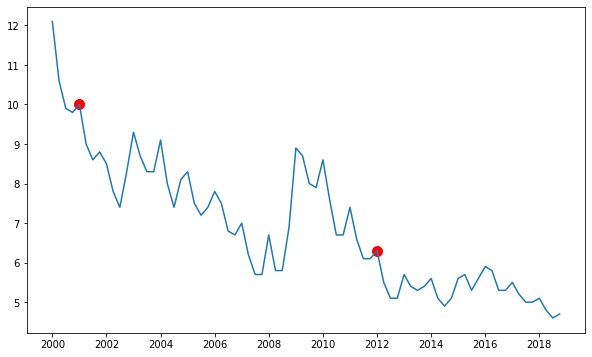

In [7]:
data = pd.read_stata('unemp_dz4.dta')

plt.figure(figsize=[10,6])
plt.plot(data['quarter'], data['unemp'])
plt.scatter([data['quarter'][4],data['quarter'][48]], [data['unemp'][4], data['unemp'][48]], color='r', marker='o',s=100)
plt.show()

data['quarter'] = np.arange(len(data))

Точки подозрительные на точки структурного сдвига выделены на графике выше.

In [8]:
x1, y1 = data['quarter'][:5], data['unemp'][:5]
x2, y2 = data['quarter'][5:49], data['unemp'][5:49]
x3, y3 = data['quarter'][49:], data['unemp'][49:]

In [9]:
def f_value(y1, x1, y2, x2):

    def find_rss (y, x):
       
        A = np.vstack([x, np.ones(len(x))]).T
        rss = np.linalg.lstsq(A, y, rcond=None)[1]
        length = len(y)
        return (rss, length)


    rss_total, n_total = find_rss(np.append(y1, y2), np.append(x1, x2))
    rss_1, n_1 = find_rss(y1, x1)
    rss_2, n_2 = find_rss(y2, x2)

    chow_nom = (rss_total - (rss_1 + rss_2)) / 2
    chow_denom = (rss_1 + rss_2) / (n_1 + n_2 - 4)
    return chow_nom / chow_denom


def p_value(y1, x1, y2, x2, **kwargs):
    F = f_value(y1, x1, y2, x2, **kwargs)
    if not F:
        return 1
    df1 = 2
    df2 = len(x1) + len(x2) - 4
    
    p_val = f.sf(F[0], df1, df2)
    return p_val

In [10]:
p_value(y1, x1, y2, x2)

0.00045634871617742745

In [11]:
p_value(y2, x2, y3, x3)

0.021127605804447707

Обе выбранные точки являются точками, в которых происходит структурный сдвиг. Мы выяснили это при помощи теста Чоу, получив p-value меньше 0.05 (данное значение мы выбрали сами). Подобные данные можно объяснить положительными событиями, происходящими на территории России (укрепление курса рубля, в следствие роста цен на нефть и грамотной экономической политики).


# Пункт 3

In [12]:
new_variable = np.zeros(76)
new_variable[:20] = np.random.randint(20, 40, 20)
new_variable[20:40] = np.random.randint(10, 20, 20)
new_variable[40:] = np.random.randint(0, 10, 36)

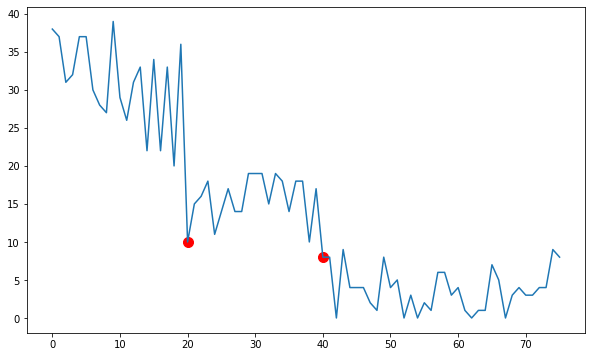

In [13]:
plt.figure(figsize=[10,6])
plt.plot(new_variable)
plt.scatter([20, 40], [new_variable[20], new_variable[40]], color='r', marker='o', s=100)
plt.show()

In [14]:
x1, y1 = data['quarter'][:20], new_variable[:20]
x2, y2 = data['quarter'][20:40], new_variable[20:40]
x3, y3 = data['quarter'][40:], new_variable[40:]

In [15]:
p_value(y1, x1, y2, x2)

3.302861841685669e-05

In [16]:
p_value(y2, x2, y3, x3)

7.367138324647647e-11

Данные сгенерированны таким образом что структурные сдвиги происходят в двух местах. Тест Чоу подтверждает это (при чем с очень большой уверенностью).